# 3D analysis

In this tutorial, we present the basics steps for a 3D stacked analysis. The main aim is to perform a spectral and morphological analysis of a given source.
We are going to analyze a generic Galactic field of the internal Science Data Challenge of CTAO. The field is rich of sources, with growing complexity of their spectral and spatial properties.

Let's start with some basic imports:

In [1]:
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion
from gammapy.datasets import MapDataset, Datasets
from gammapy.data import (
    DataStore,
    Observation,
    Observations,
)
from gammapy.estimators import ExcessMapEstimator
from gammapy.makers import (
    MapDatasetMaker, 
    SafeMaskMaker, 
    FoVBackgroundMaker
)
from gammapy.maps import MapAxis, WcsGeom
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    ExpCutoffPowerLawSpectralModel,
    FoVBackgroundModel,
    GaussianSpatialModel,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
    Models,
)

Let's investigate the Galactic field centered at the coordinates Ra, Dec = 257.500000°, -46.0°. We select all the available observations inside a cone of radius 5°.

In [2]:
# we need to set the path of the IRF:
%env CALDB=../caldb/

env: CALDB=../caldb/


In [3]:
data_store = DataStore.from_dir("../output")

In [4]:
#source coordinates
ra, dec = 257.500000 * u.deg, -46.0 * u.deg 
pointing = SkyCoord(ra, dec, frame="icrs")

In [5]:
selection = dict(
    type="sky_circle",
    frame="icrs",
    lon=pointing.ra.deg,
    lat=pointing.dec.deg,
    radius="5 deg",
)
selected_obs_table = data_store.obs_table.select_observations(selection)

In [6]:
observations = data_store.get_observations(selected_obs_table["OBS_ID"])
print(observations[0])

Observation

	obs id            : 5000002225 
 	tstart            : 61884.22
	tstop             : 61884.24
	duration          : 1575.00 s
	pointing (icrs)   : 255.2 deg, -43.8 deg

	deadtime fraction : 0.0%



Now, we generate the 'stacked' dataset:

In [7]:
energy_axis = MapAxis.from_energy_bounds(0.012, 100.0, 8, unit="TeV")

geom = WcsGeom.create(
    skydir=(pointing.ra.deg , pointing.dec.deg),
    binsz=0.01,
    width=(5, 5),
    frame="icrs",
    proj="CAR",
    axes=[energy_axis],
)

# Reduced IRFs are defined in true energy (i.e. not measured energy).
energy_axis_true = MapAxis.from_energy_bounds(
    0.001, 40, 10, unit="TeV", name="energy_true"
)

In [8]:
stacked = MapDataset.create(
    geom=geom, energy_axis_true=energy_axis_true, name="my-dataset"
)

In [9]:
offset_max = 6 * u.deg
maker = MapDatasetMaker()
maker_safe_mask = SafeMaskMaker(
    methods=["offset-max", "aeff-max"], offset_max=offset_max
)

maker_fov = FoVBackgroundMaker(method="scale")

In [10]:
for i, obs in enumerate(observations):
    # First a cutout of the target map is produced
    cutout = stacked.cutout(
        obs.get_pointing_icrs(obs.tmid), width=2 * offset_max, name=f"obs-{obs.obs_id}"
    )
    # A MapDataset is filled in this cutout geometry
    dataset = maker.run(cutout, obs)
    # The data quality cut is applied
    dataset = maker_safe_mask.run(dataset, obs)
    # fit background model
    dataset = maker_fov.run(dataset)
    print(
        f"{i} of {len(observations)}, Background norm obs {obs.obs_id}: {dataset.background_model.spectral_model.norm.value:.2f}"
    )
    # The resulting dataset cutout is stacked onto the final one
    stacked.stack(dataset)

print(stacked)

0 of 37, Background norm obs 5000002225: 1.24
1 of 37, Background norm obs 5000002226: 1.18
2 of 37, Background norm obs 5000002250: 1.13
3 of 37, Background norm obs 5000002251: 1.16
4 of 37, Background norm obs 5000002280: 1.22
5 of 37, Background norm obs 5000002307: 1.14
6 of 37, Background norm obs 5000002308: 1.47
7 of 37, Background norm obs 5000002404: 1.12
8 of 37, Background norm obs 5000002405: 1.07
9 of 37, Background norm obs 5000002436: 1.27
10 of 37, Background norm obs 5000002437: 1.68
11 of 37, Background norm obs 5000002459: 1.13
12 of 37, Background norm obs 5000002461: 1.08
13 of 37, Background norm obs 5000002635: 1.20
14 of 37, Background norm obs 5000002636: 1.08
15 of 37, Background norm obs 5000002652: 1.15
16 of 37, Background norm obs 5000002653: 1.13
17 of 37, Background norm obs 5000002666: 1.12
18 of 37, Background norm obs 5000002667: 2.53
19 of 37, Background norm obs 5000002723: 1.23
20 of 37, Background norm obs 5000002831: 1.36
21 of 37, Background no

Let's inspect the field:

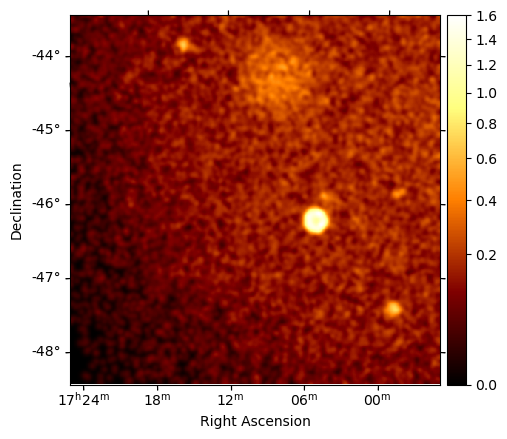

In [11]:
stacked.counts.sum_over_axes().smooth(0.03 * u.deg).plot(stretch="sqrt", add_cbar=True)
plt.show()

In [12]:
stacked.counts.sum_over_axes().write("Gal_map.fits", overwrite=True)

In [13]:
stacked.background.plot_interactive(add_cbar=True)
plt.show()

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

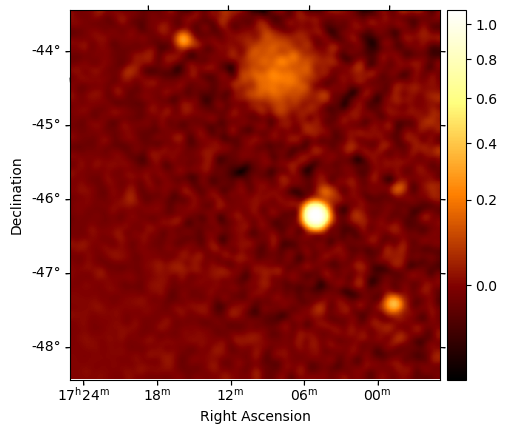

In [14]:
excess = stacked.excess.sum_over_axes()
excess.smooth("0.06 deg").plot(stretch="sqrt", add_cbar=True)
plt.show()

## 3D analysis of one source

The 3D analysis consists of a simultaneous fit of the spectral and spatial parameters of one or multiple sources. Here, we focus only on a single source, centered at the coordinates Ra, Dec = 254.7204743°, -47.4492570°. 
To perform the fit, we firstly need to define a model: we can try with a point-like morphology and a powerlaw spectral shape:

In [15]:
stacked.mask_fit = stacked.counts.geom.energy_mask(
    energy_min=0.05 * u.TeV, energy_max=None
)

#spatial_model = PointSpatialModel(
#    lon_0="254.7204743 deg", lat_0="-47.4492570 deg", frame="icrs"
#)
spatial_model = GaussianSpatialModel(
    lon_0="254.7204743 deg", lat_0="-47.4492570 deg", frame="icrs",
    sigma="0.1 deg"
)

spectral_model = PowerLawSpectralModel(
    index=2,
    amplitude=1e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1.0 * u.TeV,
)
#spectral_model = ExpCutoffPowerLawSpectralModel(
#    index=2.0020e+00,
#    amplitude=5.1154e-13 * u.Unit("cm-2 s-1 TeV-1"),
#    reference=1.0 * u.TeV,
#    _lambda = "0.1 TeV-1"
#)

model = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="gc-source",
)

# FOR SIMPLICITY, WE ASSUME THE BACKGROUND IS WELL KNOWN AND CAN BE 
# TAKEN FROM THE IRF BKG MODEL:
bkg_model = FoVBackgroundModel(dataset_name=stacked.name)
bkg_model.spectral_model.norm.value = 1.0

models_stacked = Models([model, bkg_model])

stacked.models = models_stacked

Once the model is defined, we can fit the dataset with the Gammapy `Fit` class: 

In [16]:
# For simplicity we might freeze the coordinates:
#stacked.models.parameters["lon_0"].frozen = False
#stacked.models.parameters["lat_0"].frozen = False
stacked.models.parameters["lon_0"].frozen = True
stacked.models.parameters["lat_0"].frozen = True

fit = Fit(optimize_opts={"print_level": 2})
result = fit.run(datasets=[stacked])

I MnSeedGenerator Initial state: FCN =       260198.9355 Edm =       166.9480483 NCalls =     21
I VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 680
I VariableMetricBuilder    0 - FCN =       260198.9355 Edm =       166.9480483 NCalls =     21
I VariableMetricBuilder    1 - FCN =       260133.4307 Edm =       70.81252642 NCalls =     44
I VariableMetricBuilder    2 - FCN =       260126.0388 Edm =       74.10199931 NCalls =     57
I VariableMetricBuilder    3 - FCN =       260108.7714 Edm =      0.6297968897 NCalls =     69
I VariableMetricBuilder    4 - FCN =       260107.1986 Edm =      0.5792098228 NCalls =     79
I VariableMetricBuilder    5 - FCN =       260105.6355 Edm =     0.02273841756 NCalls =     89
I VariableMetricBuilder    6 - FCN =       260105.6118 Edm =   0.0001248144829 NCalls =     99
I VariableMetricBuilder    7 - FCN =       260105.6117 Edm =   2.328839911e-06 NCalls =    109
I VariableMetricBuilder After Hessian
I VariableMetricBuild

In [17]:
print(result)

OptimizeResult

	backend    : minuit
	method     : migrad
	success    : True
	message    : Optimization terminated successfully.
	nfev       : 140
	total stat : 260105.61

CovarianceResult

	backend    : minuit
	method     : hesse
	success    : True
	message    : Hesse terminated successfully.



In [18]:
display(models_stacked.to_parameters_table())

model,type,name,value,unit,error,min,max,frozen,is_norm,link,prior
str14,str1,str9,float64,str14,float64,float64,float64,bool,bool,str1,str1
gc-source,,index,2.0020e+00,,9.757e-02,nan,nan,False,False,,
gc-source,,amplitude,5.1154e-13,TeV-1 s-1 cm-2,8.791e-14,nan,nan,False,True,,
gc-source,,reference,1.0000e+00,TeV,0.000e+00,nan,nan,True,False,,
gc-source,,lon_0,2.5472e+02,deg,0.000e+00,nan,nan,True,False,,
gc-source,,lat_0,-4.7449e+01,deg,0.000e+00,-9.000e+01,9.000e+01,True,False,,
gc-source,,sigma,4.4169e-02,deg,4.730e-03,0.000e+00,nan,False,False,,
gc-source,,e,0.0000e+00,,0.000e+00,0.000e+00,1.000e+00,True,False,,
gc-source,,phi,0.0000e+00,deg,0.000e+00,nan,nan,True,False,,
my-dataset-bkg,,norm,9.9519e-01,,5.687e-03,nan,nan,False,True,,


We can now inspect the residuals:

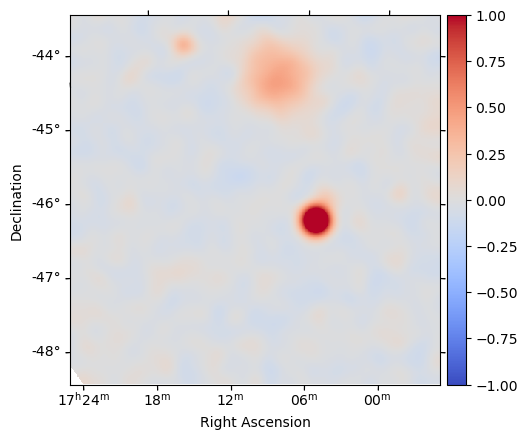

In [19]:
stacked.plot_residuals_spatial(method="diff/sqrt(model)", vmin=-1, vmax=1)
plt.show()

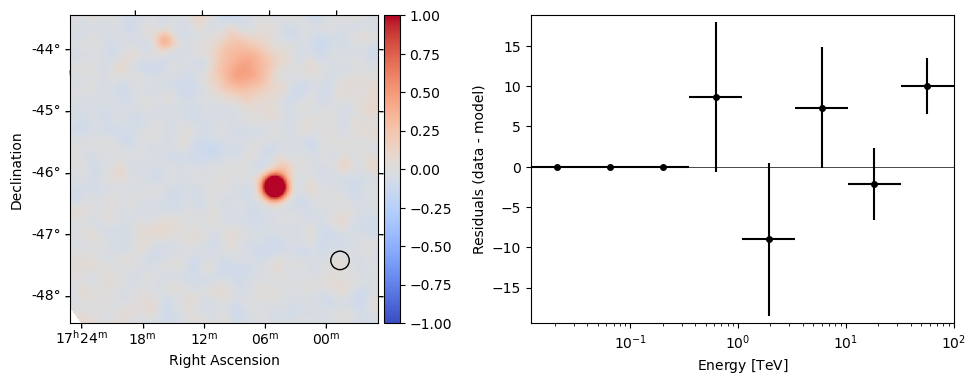

In [20]:
region = CircleSkyRegion(spatial_model.position, radius=0.15 * u.deg)
stacked.plot_residuals(
    kwargs_spatial=dict(method="diff/sqrt(model)", vmin=-1, vmax=1),
    kwargs_spectral=dict(region=region),
)
plt.show()

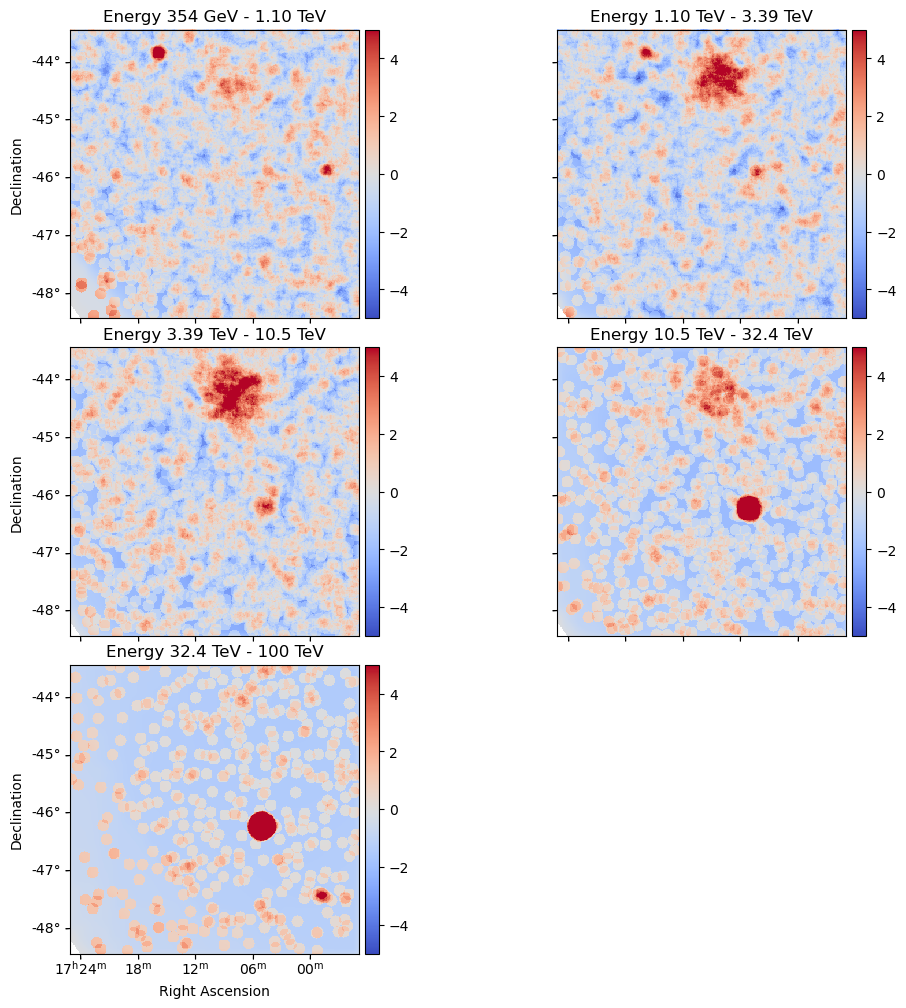

In [21]:
estimator = ExcessMapEstimator(
    correlation_radius="0.1 deg",
    selection_optional=[],
    energy_edges=[0.3, 1, 5, 10, 20, 100] * u.TeV,
)

result = estimator.run(stacked)
result["sqrt_ts"].plot_grid(
    figsize=(12, 12), cmap="coolwarm", add_cbar=True, vmin=-5, vmax=5, ncols=2
)
plt.show()

## Open problems: 

1) Try to create a small catalogue of the sources in this field. Run a source detection, and for each significant source, perform a 3D analysis. List your results!